HC Analysis - Average Gradients - Theme 4  - deprecated. 
---

By Paul Duckworth Jul 2018.


- average the GP Posterior gradient over HC occupations 

- Requres Python3 and GPFlow

- Method added to the GPflow GPR class to return gradients



In [68]:
# encoding=utf8
import os
import numpy as np
import pandas as pd
import getpass
import pickle
import string
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family': 'serif', 'serif':"Computer Modern Roman"})
rc('text', usetex=True)
from scipy.stats import gaussian_kde
%matplotlib inline

## # Input DATA set of observed Occupations and Tasks
datasets = '/home/'+ getpass.getuser() +'/Datasets/'
d = os.path.join(datasets, 'FoHealthcare/Final_dataset_24082018.xlsx')

excel_doc = pd.ExcelFile(d)
dataset = excel_doc.parse(sheet_name='ExpandedTasks')
dataset = dataset[dataset['clinical'] != 1]   # # REMOVE CLINICAL TASKS: 

task_dataset = excel_doc.parse(sheet_name='Tasks')
task_dataset = task_dataset[task_dataset['clinical'] != 1]   # # REMOVE CLINICAL TASKS: 

print("All Tasks: %s" % str(dataset.shape[0]))
print("Unique Tasks: %s" % len(dataset["Task"].unique()))

keep_hc_cols = ['Observed Occupation', 'Task', 'DWA Task', 'DWA ID', 'Task Weight', 'Automation Scores',
       'Weighted Average Automation Score']
HC_data = dataset[keep_hc_cols]
task_dataset = task_dataset[keep_hc_cols]
print("Tasks dataset: %s" % len(task_dataset["Task"].unique()))
out_file_path = "/home/scpd/Dropbox/Documents/Oxford/writing/FutureOfHealthcare_project_docs/FinalReports/Analysis_images/"

unique_occupations = dataset["Observed Occupation"].unique()
HC_data.head()



All Tasks: 264
Unique Tasks: 108
Tasks dataset: 108


,Observed Occupation,Task,DWA Task,DWA ID,Task Weight,Automation Scores,Weighted Average Automation Score
0,Administrator,Address problems that arise with building,"Notify others of emergencies, problems, or haz...",4.A.4.a.2.I08.D07; 4.A.4.a.2.I08.D04; 4.A.4.a....,0.20; 0.20; 0.20; 0.20; 0.20;,3.27; 2.90; 3.30; 3.10; 2.46;,3.004637
1,Administrator,Answer phone,Answer telephones to direct calls or provide i...,4.A.4.a.3.I03.D11,1.00;,3.15;,3.153151
2,Administrator,Checking for errors in paperwork,Check data for recording errors.,4.A.2.a.2.I01.D08,1.00;,3.27;,3.272835
3,Administrator,Cleaning up information in the patients electr...,Process healthcare paperwork.,4.A.4.c.1.I01.D03,1.00;,2.91;,2.913987
4,Administrator,Connecting human resources/making introduction...,Relay information between personnel.,4.A.4.a.2.I03.D11,1.00;,3.38;,3.375000


In [36]:
from __future__ import print_function, absolute_import

import gpflow
import tensorflow as tf
from gpflow.mean_functions import Linear
from gpflow.models import GPR
from gpflow.decors import autoflow

float_type = gpflow.settings.dtypes.float_type

class GPR_with_grad(GPR):
    def __init__(self, X, Y, kern):
        
        GPR.__init__(self, X, Y, kern)
        print("m = GPR with posterior gradients")

    @autoflow((float_type, [None, None]))
    def compute_posterior_grad_at(self, Xnew):
        """
        Compute the gradient of the posterior mean function at a specific valuem, Xnew.
        """
        pred_mean, pred_var = self._build_predict(Xnew)
        return tf.gradients(pred_mean, Xnew)
    
    

In [37]:
import os
import copy
import numpy as np
import pandas as pd
import getpass
import pickle as pickle
# import _pickle as pickle
import gpflow
import pylab as plt
%matplotlib inline
import itertools
import random
from sklearn.model_selection import KFold

with open('icml_data/tasks_by_skills_2018_v5_both_weights_unit_normed.p', 'rb') as f:
    icml_data = pickle.load(f, encoding='latin1')

# # ONET dataset location:     
# datasets = '/home/'+ getpass.getuser() +'/Datasets/ONET/'

#Misc settings
ms = 11  # marker size in plots
random.seed =  6   # random seed

- Train just one GP using all the data model and calculate average gradients, per HC occupation: 

## LOAD THE ICML FEATURE VECTOR DATA: 

In [38]:
(X, test, y_) = icml_data

y = y_["GT Score 1-4"]   # do not use the 0 - 4 score (where "unsure" is a valid answer)
cols = test.columns[1:]

## Train set:
x_train = X[cols].as_matrix()
y_train = y.values.reshape(x_train.shape[0], 1)

## Test set only:
x_test = test[cols].as_matrix()

## This is the icml "automation of DWA data"
print("training data X = ", x_train.shape, ". test set = ", test.shape, ". ground truth y = ", y_train.shape)

## All dwa feature vectors:
all_dwa_features = X.append(test)[test.columns]
print("all 120 features =", all_dwa_features.shape)

all_dwa_features.head()

training data X =  (314, 120) . test set =  (1753, 121) . ground truth y =  (314, 1)
all 120 features = (2067, 121)


,DWA ID,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,4.A.1.a.1.I01.D01,3.206031,3.798952,3.308485,3.255014,3.465971,1.352048,1.586345,1.043563,2.842514,...,1.066215,1.153341,1.217814,2.520910,1.451737,3.352828,3.520535,1.413655,3.788355,3.342607
3,4.A.1.a.1.I01.D04,3.241681,3.920024,3.189726,3.530566,3.621624,1.091567,1.192623,1.053746,3.022365,...,1.517075,1.839739,1.700592,2.768509,1.993082,2.454878,2.957088,1.224493,3.841295,3.437580
11,4.A.1.a.1.I02.D08,3.151530,3.621651,3.387262,3.101375,3.626099,1.573449,1.762136,1.336109,2.818544,...,1.204843,1.301533,1.415211,2.663005,1.708003,2.827332,3.327724,1.693029,3.825821,3.568996
12,4.A.1.a.1.I02.D09,2.692799,3.073483,2.878213,3.096213,3.190303,2.117181,2.339092,1.657604,2.499585,...,2.345798,2.835105,3.150562,2.622120,3.293398,2.718646,3.235995,2.032858,2.935040,2.543448
13,4.A.1.a.1.I02.D10,2.791359,3.322016,3.040584,3.132688,3.338834,2.130404,1.735284,1.215225,2.635423,...,2.169805,2.295489,2.602196,2.747473,2.551150,2.789201,2.908992,2.024323,3.251757,3.052460


In [39]:
X.shape, test.shape, y.shape, test.shape[0] + X.shape[0]

((314, 123), (1753, 121), (314,), 2067)

In [40]:
# # # These are the column name groupings... (used in the latex outputs)
skills = cols[:35]
knowledges = cols[35:68]
abilities = cols[68:]

characteristic_dict = {}
for i in skills:
    characteristic_dict[i] = "skill"
for i in knowledges:
    characteristic_dict[i] = "knowledge"
for i in abilities:
    characteristic_dict[i] = "ability"
# characteristic_dict

## Checking how many DWAs in the Train set are used in the Healthcare Dataset

In [41]:
all_dwas_in_healthcare = []
for index, row in HC_data.iterrows():
    dwas = [i.strip() for i in row['DWA ID'].split(";")]
    all_dwas_in_healthcare.extend(dwas)
    
healthcare_dwas_in_training_set = list(set(X['DWA ID'].values) & set(all_dwas_in_healthcare))
healthcare_dwas_in_training_set[:5]

['4.A.4.a.8.I03.D06',
 '4.A.4.b.3.I04.D16',
 '4.A.4.a.2.I03.D20',
 '4.A.4.c.1.I03.D06',
 '4.A.4.a.2.I08.D07']

## Train GP Model from Training set - with the Gradient GPR model

In [42]:
# Subset of the features - to assess whether arcCosine will converge
#     skills = test.columns[1:1+34]
#     know = test.columns[36:36+33]
#     ability = test.columns[36+33:]
#     cols = skills.append(know)


## Zero mean Normalise the train set :)
# X_n = (X[cols]-X[cols].mean())/X[cols].std()
# norm_X = pd.merge(X[['DWA ID', 'GT Score 1-4']], X_n, how='left', left_index=True, right_index=True)
# X = norm_X.copy()
# print(sum(X[cols].mean(axis=0)))

# RBF Kernel
in_dims = cols.shape[0]
k = gpflow.kernels.RBF(in_dims)

m = GPR_with_grad(x_train, y_train, kern=k)
gpflow.train.ScipyOptimizer().minimize(m)

m = GPR with posterior gradients
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 241.853182
  Number of iterations: 23
  Number of functions evaluations: 25


In [43]:
# pd.DataFrame(sorted(y_train)).plot()
y_train[:5]

array([[2.3125    ],
       [2.23397436],
       [3.33333333],
       [2.69615385],
       [3.05909091]])

In [44]:
y_pred, Vp = m.predict_y(all_dwa_features[cols])#, full_cov=False)
y_pred[:5]

array([[2.56919991],
       [2.11772708],
       [3.05650487],
       [2.84415189],
       [2.98823836]])

## Find the DWAs that disagree in Automation Score the most: 

- note: the icml analysis and the healthcare report, use the expert scores as ground truth, and not the predicted values for these (314) dwas.

314 (0.3499419138261853, 0.2615412148647812)
    ID   y_train    y_pred  difference
0  191  3.259921  2.017889    1.242032
1  302  3.800000  2.641885    1.158115
2   91  3.500000  2.369699    1.130301
3  272  3.600000  2.493700    1.106300
4  183  3.750000  2.740487    1.009513


    ID   y_train    y_pred  difference
0  150  3.454545  3.457146    0.002601
1  133  3.090909  3.087930    0.002979
2  174  3.000000  3.003735    0.003735
3   85  3.000000  2.994628    0.005372
4   31  2.687500  2.681996    0.005504


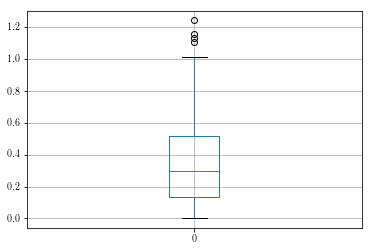

In [45]:
number_of_disagreements = len(y_train)  # length of ground truth set
diffs = [np.abs(train-pred)[0] for train, pred in zip(y_train, y_pred)]
ids_which_disagree_poss_the_most = list(np.array(diffs).argsort()[-number_of_disagreements:][::-1])
ids_which_disagree_neg_the_most = list(np.array(diffs).argsort()[-number_of_disagreements:][::1])

col_names = ["ID","y_train","y_pred","difference"]

disagrement_p_outliers = pd.DataFrame([(i, y_train[i][0], y_pred[i][0], diffs[i]) for i in ids_which_disagree_poss_the_most], columns = col_names)
disagrement_n_outliers = pd.DataFrame([(i, y_train[i][0], y_pred[i][0], diffs[i]) for i in ids_which_disagree_neg_the_most], columns = col_names)
# table_of_disagrements.to_latex()
# table_of_disagrements.to_csv("/tmp/table_of_disagrements.xls")

print(len(diffs), (np.mean(diffs), np.std(diffs)))
pd.DataFrame(diffs).boxplot()

print(disagrement_p_outliers.head())
print("\n")
print(disagrement_n_outliers.head())

In [46]:
disagrement_p_outliers

,ID,y_train,y_pred,difference
0,191,3.259921,2.017889,1.242032
1,302,3.800000,2.641885,1.158115
2,91,3.500000,2.369699,1.130301
3,272,3.600000,2.493700,1.106300
4,183,3.750000,2.740487,1.009513
5,184,3.875000,2.899646,0.975354
6,203,3.125000,2.151668,0.973332
7,238,1.888889,2.845916,0.957028
8,90,3.833333,2.909032,0.924301
9,29,3.571429,2.683945,0.887484


In [47]:
df_of_disagreements = X  #.iloc[ids_which_disagree_the_most].reset_index()
df_of_disagreements['IWA ID'] = df_of_disagreements['DWA ID'].str.slice(0,-4)    # create IWA ID

## ADD DWA and IWA titles:
DWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/DWA Reference.txt'), sep='\t')[['DWA ID', 'DWA Title']]
IWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/IWA Reference.txt'), sep='\t')[['IWA ID', 'IWA Title']]

temp = pd.merge(df_of_disagreements, DWAref,  how='left', left_on=['DWA ID'], right_on = ['DWA ID'])
df_of_disagreements2 = pd.merge(temp, IWAref,  how='left', left_on=['IWA ID'], right_on = ['IWA ID'])
df_of_disagreements3 = pd.merge(df_of_disagreements2, disagrement_p_outliers, left_index=True, right_index=True)

col_names = ['DWA ID', 'DWA Title', 'IWA Title', "y_train", "y_pred", "difference"]
df_of_disagreements3[col_names].head()

,DWA ID,DWA Title,IWA Title,y_train,y_pred,difference
0,4.A.1.a.1.I01.D01,Review art or design materials.,Study details of artistic productions.,3.259921,2.017889,1.242032
1,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,Study details of artistic productions.,3.800000,2.641885,1.158115
2,4.A.1.a.1.I02.D08,Review technical documents to plan work.,Read documents or materials to inform work pro...,3.500000,2.369699,1.130301
3,4.A.1.a.1.I02.D09,Review blueprints or specifications to determi...,Read documents or materials to inform work pro...,3.600000,2.493700,1.106300
4,4.A.1.a.1.I02.D10,Review work orders or schedules to determine o...,Read documents or materials to inform work pro...,3.750000,2.740487,1.009513


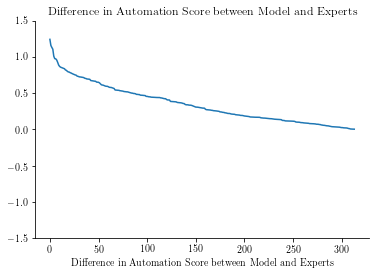

In [48]:
fig, ax = plt.subplots()
ax.plot(df_of_disagreements3["difference"])

ax.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_xlabel("Difference in Automation Score between Model and Experts")
ax.set_ylabel("")
ax.set_ylim([-1.5,1.5])
ax.set_title("Difference in Automation Score between Model and Experts")
plt.show()

## Find the disagreement regarding the Healthcare DWAs only: 

In [49]:
healthcare_disagreements = df_of_disagreements3[df_of_disagreements3['DWA ID'].isin(healthcare_dwas_in_training_set)][col_names]
df_of_disagreements3[df_of_disagreements3['DWA ID'].isin(healthcare_dwas_in_training_set)][col_names]

healthcare_disagreements.to_csv("/tmp/disagreing healthcare dwa scores.xls")
healthcare_disagreements["difference"].mean()

0.15224922407091993

#### Theme 4: What are the qualities and characteristics of tasks that can(not) be automated

In [34]:
def risk_cat(score):
    return int(np.floor(score))

# Add the risk category as a new column
task_dataset["cat_n"] = task_dataset["Weighted Average Automation Score"].apply(lambda col: risk_cat(col))
low = task_dataset[task_dataset["cat_n"] == 1]
med = task_dataset[task_dataset["cat_n"] == 2]
high = task_dataset[task_dataset["cat_n"] == 3]
print("These are our sets to calcluate gradients over: ", low.shape, med.shape, high.shape)
low

These are our sets to calcluate gradients over:  (3, 8) (87, 8) (47, 8)


,Observed Occupation,Task,DWA Task,DWA ID,Task Weight,Automation Scores,Weighted Average Automation Score,cat_n
72,Practice Manager,Staff recruitment,Recruit personnel.,4.A.4.c.2.I01.D05,1.00;,1.65;,1.653846,1
81,Practice Manager,Conducting training in-person,Conduct employee training programs.; Train emp...,4.A.4.b.3.I04.D16; 4.A.4.b.3.I04.D14,0.50; 0.50;,1.31; 2.25;,1.778846,1
91,Practice Nurse,Provide counseling/administer medications,"Provide counsel, comfort, or encouragement to ...",4.A.4.b.6.I10.D03; 4.A.4.b.6.I10.D07,0.50; 0.50;,2.47; 1.44;,1.956845,1


In [50]:
def print_top(col_name, cap):
     print("\\begin{table}[h!] \
    \\caption{%s} \
    \\centering \\small \
    \\begin{tabular}{@{}lc@{}} \\toprule{}  \
    O*NET Feature & %s  \\\\  \\midrule" % (cap, col_name))

def print_bot(label):
    print("\\bottomrule \
    \\end{tabular} \
    \\label{tab:%s} \
    \\end{table}" % label)
    return


## This generates a table for each Automatable Risk Group:

In [52]:


number_of_features_presented = 5

for subset_of_data, risk in zip([low, high, med ], ["not-automatable", "automatable", "partly-automatable"]):
    print("\n %%", risk, subset_of_data.shape)
    
    avg_features, dwa_grads_per_set = [],[]
    for index, row in subset_of_data.iterrows():
        dwas = [i.strip() for i in row['DWA ID'].split(";")]
#         print(dwas)

        weights = [i.strip() for i in row['Task Weight'].split(";")]
        X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 

        # average dwa feature vector for heatlthcare task
        avg_features.append(X_subset.mean(axis=0)) 

        # compute gradients at this point
        grads = m.compute_posterior_grad_at(X_subset)[0].mean(axis=0)    # averages over the (multiple) gradients at the dwa's
        dwa_grads_per_set.append(grads)

    average_grads = np.vstack(dwa_grads_per_set).mean(axis=0)
    avg_features =  np.vstack(avg_features).mean(axis=0)

    # # These are the characteristics of those tasks (in the sub-set)
    neg_grads  = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][:number_of_features_presented]
#     poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][-number_of_features_presented:]  ## This means they are sorted differently (but gives you the same set of 10)
    poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols), reverse=True)][:number_of_features_presented]

    ### Print the results to latex:
    
    print("\n %% AVERAGE FEATURE DIFFERENCES:")
    caption = "Largest feature differences relative to the population for \\textcolor{vubbleu}{%s} healthcare tasks" % risk
    print_top("Feature Difference", caption)
    mean_dataset_features = all_dwa_features.mean(axis=0)
    percentage_diffs = ((avg_features - mean_dataset_features) / mean_dataset_features)*100
    
    # # REMOVED THE NEGATIVE FEATURES
#     for i, j in sorted(zip(percentage_diffs, cols))[:number_of_features_presented]:
#         print(j , "(%s) & \\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 
    for i, j in sorted(zip( percentage_diffs, cols), reverse=True)[:number_of_features_presented]:
        print(j , "(%s) & +\\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 
    print("\\midrule")
    label = "tab:feature_diff_%s" % risk
    print_bot(label)
        
    
    print("\n %% AVERAGE FEATURE GRADIENTS:")    
    caption = "O*NET features with the largest (possitive and negative) derivatives for \\textcolor{vubbleu}{%s} healthcare tasks." % risk
    print_top("Feature Gradient", caption)
    
 # # REMOVED THE NEGATIVE FEATURES
#     for (i, j) in neg_grads:
#         print(j , "(%s) & %0.3f  \\\\ " % (characteristic_dict[j], i)) 
    
    for (i, j) in poss_grads:
        print(j , "(%s) & +%0.3f  \\\\ " % (characteristic_dict[j], i))
    print("\\midrule")
    label = "tab:feature_grad_%s" % risk    
    print_bot(label)
    


 %% not-automatable (3, 8)

 %% AVERAGE FEATURE DIFFERENCES:
\begin{table}[h!]     \caption{Largest feature differences relative to the population for \textcolor{vubbleu}{not-automatable} healthcare tasks}     \centering \small     \begin{tabular}{@{}lc@{}} \toprule{}      O*NET Feature & Feature Difference  \\  \midrule
Therapy and Counseling (knowledge) & +\SI{51.0}{\percent}  \\ 
Philosophy and Theology (knowledge) & +\SI{44.1}{\percent}  \\ 
Psychology (knowledge) & +\SI{38.1}{\percent}  \\ 
Sociology and Anthropology (knowledge) & +\SI{37.9}{\percent}  \\ 
Personnel and Human Resources (knowledge) & +\SI{33.6}{\percent}  \\ 
\midrule
\bottomrule     \end{tabular}     \label{tab:tab:feature_diff_not-automatable}     \end{table}

 %% AVERAGE FEATURE GRADIENTS:
\begin{table}[h!]     \caption{O*NET features with the largest (possitive and negative) derivatives for \textcolor{vubbleu}{not-automatable} healthcare tasks.}     \centering \small     \begin{tabular}{@{}lc@{}} \toprule{}   

## The same info, but accumulating into just 2 tables. 

In [55]:
def print_top2(col_name, cap):
     print("\\begin{table}[h!] \
    \\caption{%s} \
    \\centering \\small \
    \\begin{tabular}{@{}llc@{}} \\toprule{}  \
    \\textbf{Risk Category} & \\textbf{O*NET Feature} & \\textbf{%s}  \\\\  \\midrule" % (cap, col_name))


In [56]:
print("%% taken from AverageGradients - Theme4.ipynb,\n")

number_of_features_presented = 5

caption = "Largest feature differences relative to the dataset by risk category"
print_top2("Feature Difference", caption)
for cnt, (subset_of_data, risk) in enumerate(zip([low, high, med ], ["not-automatable", "automatable", "partly-automatable"])):
    print("\n %%", risk, subset_of_data.shape)
    
    avg_features, dwa_grads_per_set = [],[]
    for index, row in subset_of_data.iterrows():
        dwas = [i.strip() for i in row['DWA ID'].split(";")]
#         print(dwas)

        weights = [i.strip() for i in row['Task Weight'].split(";")]
        X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 

        # average dwa feature vector for heatlthcare task
        avg_features.append(X_subset.mean(axis=0)) 

        # compute gradients at this point
        grads = m.compute_posterior_grad_at(X_subset)[0].mean(axis=0)    # averages over the (multiple) gradients at the dwa's
        dwa_grads_per_set.append(grads)

    average_grads = np.vstack(dwa_grads_per_set).mean(axis=0)
    avg_features =  np.vstack(avg_features).mean(axis=0)

    # # These are the characteristics of those tasks (in the sub-set)
    neg_grads  = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][:number_of_features_presented]
#     poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][-number_of_features_presented:]  ## This means they are sorted differently (but gives you the same set of 10)
    poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols), reverse=True)][:number_of_features_presented]

    print("\n %% AVERAGE FEATURE DIFFERENCES:")
    mean_dataset_features = all_dwa_features.mean(axis=0)
    percentage_diffs = ((avg_features - mean_dataset_features) / mean_dataset_features)*100
    for ind, (i, j) in enumerate(sorted(zip( percentage_diffs, cols), reverse=True)[:number_of_features_presented]):
        if ind==0:
            print(risk, " & ", j , "(%s) & +\\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 
        else:
            print(" & ",j , "(%s) & +\\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i))   

#         REMOVE NEGATIVE FEATURES
#     print("\\cdashline{2-3}")       
#     for i, j in sorted(zip(percentage_diffs, cols))[:number_of_features_presented]:
#             print(" & ", j , "(%s) & \\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 

    if cnt != 2: print("\\midrule")
label = "feature_diffs"
print_bot(label)

print("\n")

 # # #  JUST THE SAME LOOP AGAIN BECUASE IM LAZY...
    
caption = "O*NET features with the largest average derivatives by risk category"
print_top2("Feature Gradient", caption)
for cnt, (subset_of_data, risk) in enumerate(zip([low, high, med ], ["not-automatable", "automatable", "partly-automatable"])):
    print("\n %%", risk, subset_of_data.shape)
    
    avg_features, dwa_grads_per_set = [],[]
    for index, row in subset_of_data.iterrows():
        dwas = [i.strip() for i in row['DWA ID'].split(";")]
#         print(dwas)

        weights = [i.strip() for i in row['Task Weight'].split(";")]
        X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 

        # average dwa feature vector for heatlthcare task
        avg_features.append(X_subset.mean(axis=0)) 

        # compute gradients at this point
        grads = m.compute_posterior_grad_at(X_subset)[0].mean(axis=0)    # averages over the (multiple) gradients at the dwa's
        dwa_grads_per_set.append(grads)

    average_grads = np.vstack(dwa_grads_per_set).mean(axis=0)
    avg_features =  np.vstack(avg_features).mean(axis=0)

    # # These are the characteristics of those tasks (in the sub-set)
    neg_grads  = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][:number_of_features_presented]
#     poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][-number_of_features_presented:]  ## This means they are sorted differently (but gives you the same set of 10)
    poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols), reverse=True)][:number_of_features_presented]

    ### Print the results to latex:
    print("\n %% AVERAGE FEATURE GRADIENTS:")    

    for ind, (i, j) in enumerate(poss_grads):
        if ind==0:
            print(risk, " & ",  j , "(%s) & +%0.3f  \\\\ " % (characteristic_dict[j], i))
        else:
            print(" & ", j , "(%s) & +%0.3f  \\\\ " % (characteristic_dict[j], i))
            
#         REMOVE NEGATIVE FEATURES            
#     print("\\cdashline{2-3}")  
#     for (i, j) in neg_grads:
#         print(" & ", j , "(%s) & %0.3f  \\\\ " % (characteristic_dict[j], i)) 


    if cnt != 2: print("\\midrule")
label = "feature_grads"
print_bot(label)  
    


%% taken from AverageGradients - Theme4.ipynb,

\begin{table}[h!]     \caption{Largest feature differences relative to the dataset by risk category}     \centering \small     \begin{tabular}{@{}llc@{}} \toprule{}      \textbf{Risk Category} & \textbf{O*NET Feature} & \textbf{Feature Difference}  \\  \midrule

 %% not-automatable (3, 8)

 %% AVERAGE FEATURE DIFFERENCES:
not-automatable  &  Therapy and Counseling (knowledge) & +\SI{51.0}{\percent}  \\ 
 &  Philosophy and Theology (knowledge) & +\SI{44.1}{\percent}  \\ 
 &  Psychology (knowledge) & +\SI{38.1}{\percent}  \\ 
 &  Sociology and Anthropology (knowledge) & +\SI{37.9}{\percent}  \\ 
 &  Personnel and Human Resources (knowledge) & +\SI{33.6}{\percent}  \\ 
\midrule

 %% automatable (47, 8)

 %% AVERAGE FEATURE DIFFERENCES:
automatable  &  Clerical (knowledge) & +\SI{24.6}{\percent}  \\ 
 &  Customer and Personal Service (knowledge) & +\SI{14.0}{\percent}  \\ 
 &  Service Orientation (skill) & +\SI{6.0}{\percent}  \\ 
 &  Compute

## Compute Gradients for each Occupation's (set of) DWAs: 

In [59]:
all_dwa_features[all_dwa_features["DWA ID"] == '4.A.4.c.1.I01.D02']

,DWA ID,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
1687,4.A.4.c.1.I01.D02,2.931675,3.702262,2.933205,2.938942,3.309955,1.042923,1.027559,1.0,2.396856,...,1.147929,1.220046,1.32365,2.528455,1.490903,2.019895,2.122965,1.37373,3.827284,3.638346


# # Occupation Level Appendix...


In [60]:
def print_3_task_table(data, occu, cap, label, max_length = 55):
    display_number_of_tasks = 3
    
    display_cols = ["Task", "Weighted Average Automation Score"]
    dataset_tasks = data.sort_values(by="Weighted Average Automation Score")

    low = dataset_tasks.iloc[:display_number_of_tasks,:][display_cols]
    high = dataset_tasks.iloc[-display_number_of_tasks:,:].iloc[::-1][display_cols]
    

    print("\\begin{center} \
    \\begin{longtable}[t]{K{.1\linewidth}K{.6\linewidth}C{.15\linewidth}} \
    \\caption*{%s} \\label{%s} \\\\ \
    \\small \
       & \\textbf{Task} & \\textbf{Automation Score}  \\\\  \\midrule" % (cap, label))
 
    for cnt, (i, row) in enumerate(low.iterrows()):
        if cnt == 0:
            print("Lowest & %s & %0.3f \\\\" % (row[0], row[1] ) )
        else:
            print(" & %s & %0.3f \\\\" % (row[0], row[1] ) )
    print("\\cdashline{2-3}")
    
    for cnt, (i, row) in enumerate(high.iterrows()):
        if cnt == 0:
            print("Highest & %s & %0.3f \\\\" % (row[0], row[1] ) )    
        else:
            print(" &  %s & %0.3f \\\\" % (row[0], row[1] ) )

    print("\\bottomrule \
    \\end{longtable} \
    \end{center} \
    ")
    return

In [61]:
def print_top3(col_name, cap):
     print("\\begin{table}[h!] \
    \\caption*{%s} \
    \\centering \\small \
    \\begin{tabular}{@{}lc@{}} \
    \\textbf{O*NET Feature} & \\textbf{%s}  \\\\  \\midrule" % (cap, col_name))

In [62]:
def print_figure(cap, lab, loc, nam, w=0.4):
    print("\\begin{figure}[h!] \
    \\centering \
    \\includegraphics[width=%s\linewidth]{%s/%s.pdf}  \
    \\caption{%s} \
    \\label{%s} \
    \\end{figure}"  % (w, loc, nam, cap, lab) )
    return

In [77]:
print("%% taken from AverageGradients - Theme4.ipynb,\n")

number_of_features_presented = 5

for occu in unique_occupations:
    subset_of_data = HC_data[HC_data["Observed Occupation"] == occu]
    
    risk = occu.replace(" ","_")
    print("\n %%", risk, subset_of_data.shape)
    print("\\subsubsection*{%s}" % occu)
    
    
    # # This is the bar chart of each occupation's task by category
#     cap="Task Automatability groups for \\textcolor{vubbleu}{%s}" % occu
#     lab = "app:fig:%s" %risk
#     loc = "Back_Matter/Appendix/occupation_level_images"
#     nam = "task_categories_%s" % risk
#     print_figure(cap, lab, loc, nam)
   

    # # In here - put the 3 most, and the 3 least automatable tasks... 
    caption = "\\textcolor{vubbleu}{%s}: Three most and least automatable tasks" % occu
    label = "app:tab:3tasks_%s" % risk
    print_3_task_table(subset_of_data, occu,  caption, label)
    
    
    avg_features, dwa_grads_per_set = [],[]
    for index, row in subset_of_data.iterrows():
        dwas = [i.strip() for i in row['DWA ID'].split(";")]
#         print(dwas)

        weights = [i.strip() for i in row['Task Weight'].split(";")]
        X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 

        # average dwa feature vector for heatlthcare task
        avg_features.append(X_subset.mean(axis=0)) 

        # compute gradients at this point
        grads = m.compute_posterior_grad_at(X_subset)[0].mean(axis=0)    # averages over the (multiple) gradients at the dwa's
        dwa_grads_per_set.append(grads)

    average_grads = np.vstack(dwa_grads_per_set).mean(axis=0)
    avg_features =  np.vstack(avg_features).mean(axis=0)

    # # These are the characteristics of those tasks (in the sub-set)
    neg_grads  = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][:number_of_features_presented]
#     poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][-number_of_features_presented:]  ## This means they are sorted differently (but gives you the same set of 10)
    poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols), reverse=True)][:number_of_features_presented]
   
    
    ### Print the results to latex:
    print("\n %% AVERAGE FEATURE DIFFERENCES:")
    caption = "\\textcolor{vubbleu}{%s}: Largest feature differences relative to the population" % occu
    print_top3("Feature Difference", caption)
    mean_dataset_features = all_dwa_features.mean(axis=0)
    percentage_diffs = ((avg_features - mean_dataset_features) / mean_dataset_features)*100    
    for i, j in sorted(zip( percentage_diffs, cols), reverse=True)[:number_of_features_presented]:
        print(j.replace("_", "\_")  , "(%s) & +\\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 
    print("\\midrule")    
    for i, j in sorted(zip(percentage_diffs, cols))[:number_of_features_presented]:
        print(j.replace("_", "\_")  , "(%s) & \\SI{%0.1f}{\\percent}  \\\\ " % (characteristic_dict[j], i)) 
    label = "tab:feature_diff_%s" % risk
    print_bot(label)
        
    
    print("\n %% AVERAGE FEATURE GRADIENTS:")    
    caption = "\\textcolor{vubbleu}{%s}: O*NET features with the largest (positive and negative) derivatives." % occu
    print_top3("Feature Gradient", caption)
    for (i, j) in neg_grads:
        print(j.replace("_", "\_")  , "(%s) & %0.3f  \\\\ " % (characteristic_dict[j], i)) 
    print("\\midrule")        
    for (i, j) in poss_grads:
        print(j.replace("_", "\_")  , "(%s) & +%0.3f  \\\\ " % (characteristic_dict[j], i))
    label = "tab:feature_grad_%s" % risk    
    print_bot(label)
    
    print("\\newpage")
    


%% taken from AverageGradients - Theme4.ipynb,


 %% Administrator (40, 7)
\subsubsection*{Administrator}
\begin{center}     \begin{longtable}[t]{K{.1\linewidth}K{.6\linewidth}C{.15\linewidth}}     \caption*{\textcolor{vubbleu}{Administrator}: Three most and least automatable tasks} \label{app:tab:3tasks_Administrator} \\     \small        & \textbf{Task} & \textbf{Automation Score}  \\  \midrule
Lowest & Staff recruitment & 1.654 \\
 & Manage pension schemes & 2.355 \\
 & Write notes on paper & 2.465 \\
\cdashline{2-3}
Highest & Print letters & 3.522 \\
 &  Use texting service or patient management service to contact patients for different clinics and to send reminders. & 3.500 \\
 &  Use software or database to paper records that are in storage either onsite or offsite & 3.482 \\
\bottomrule     \end{longtable}     \end{center}     

 %% AVERAGE FEATURE DIFFERENCES:
\begin{table}[h!]     \caption*{\textcolor{vubbleu}{Administrator}: Largest feature differences relative to the populat

In [70]:
### The Original (just-) Gradients Code:

task_grads, occu_grads = {}, {}
to_print_grads = {}

unique_dwas_in_train_set = []

for occu in unique_occupations:
    print("Gradients for: ", occu)
    task_grads[occu] = []
    
    for index, row in HC_data[HC_data["Observed Occupation"] == occu].iterrows():
    #     print(index)

        dwas = [i.strip() for i in row['DWA ID'].split(";")]
        weights = [i.strip() for i in row['Task Weight'].split(";")]
        X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 
       
        grads_at = m.compute_posterior_grad_at(X_subset)[0]
#         print(grads_at.shape)
        task_grad = grads_at.mean(axis=0)   # not using the weights - assuming all tasks are made equally.
        
    #     print(grads_at[0][:5])
    #     print(task_grad)
    #     print(X_subset.shape, grads_at.shape, task_grad.shape)
        task_grads[occu].append(task_grad)
        
    occu_grads[occu] = np.array(task_grads[occu]).mean(axis=0)
    to_print_grads[occu] = [ (cols[cnt], cnt, "%0.3f" % i)  for cnt, i in enumerate(occu_grads[occu])]

Gradients for:  Administrator
Gradients for:  Deputy Practice Manager
Gradients for:  General Practitioner
Gradients for:  Healthcare Assistant
Gradients for:  Nurse Practitioner
Gradients for:  Pharmacy Technician
Gradients for:  Phlebotomist
Gradients for:  Practice Manager
Gradients for:  Practice Nurse
Gradients for:  Practice Pharmacist
Gradients for:  Prescription Clerk
Gradients for:  Receptionist
Gradients for:  Scanning Clerk
Gradients for:  Secretary
Gradients for:  Summariser


In [71]:
display = 5
# title("Average Gradients per WA")
# ylabel("Average Gradient")
# xlabel("O*NET Numeric Attribute")
for i, occu in enumerate(unique_occupations):
        
    print(occu)
    grads = to_print_grads[occu]
    print("Positive Gradients")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[-display:]][::-1]:
        print(i)
    print("Negative Gradients")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[:display]]:
        print(i)
    print("")

Administrator
Positive Gradients
('Clerical', 39, '0.141')
('Depth Perception', 73, '0.109')
('Number Facility', 94, '0.107')
('Control Precision', 71, '0.104')
('Mathematical Reasoning', 89, '0.094')
Negative Gradients
('Equipment Maintenance', 5, '-0.000')
('Operation Monitoring', 17, '-0.000')
('Transportation', 67, '-0.001')
('Foreign Language', 50, '-0.002')
('Physics', 59, '-0.003')

Deputy Practice Manager
Positive Gradients
('Clerical', 39, '0.141')
('Depth Perception', 73, '0.108')
('Number Facility', 94, '0.106')
('Control Precision', 71, '0.104')
('Mathematical Reasoning', 89, '0.093')
Negative Gradients
('Equipment Maintenance', 5, '-0.001')
('Foreign Language', 50, '-0.001')
('Operation Monitoring', 17, '-0.002')
('Gross Body Coordination', 83, '-0.002')
('Physics', 59, '-0.004')

General Practitioner
Positive Gradients
('Clerical', 39, '0.140')
('Depth Perception', 73, '0.108')
('Number Facility', 94, '0.107')
('Control Precision', 71, '0.104')
('Mathematical Reasoning', 

In [72]:
display = 5
for i, (occu, grads) in enumerate(to_print_grads.items()):
    print("\n", occu)

    print("positive")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[-display:]][::-1]:
        print("%s & +%s & (??) \\\\" % (i[0], i[2]))
        
    print("negative")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[:display]]:
        print("%s & %s & (??) \\\\" % (i[0], i[2]))


 Phlebotomist
positive
Clerical & +0.131 & (??) \\
Number Facility & +0.096 & (??) \\
Mathematical Reasoning & +0.087 & (??) \\
Depth Perception & +0.085 & (??) \\
Mathematics_x & +0.080 & (??) \\
negative
Critical Thinking & -0.001 & (??) \\
Persuasion & -0.002 & (??) \\
Design & -0.002 & (??) \\
Trunk Strength & -0.002 & (??) \\
Speaking & -0.003 & (??) \\

 Practice Pharmacist
positive
Clerical & +0.141 & (??) \\
Number Facility & +0.106 & (??) \\
Depth Perception & +0.106 & (??) \\
Control Precision & +0.102 & (??) \\
Mathematical Reasoning & +0.093 & (??) \\
negative
Foreign Language & -0.002 & (??) \\
Equipment Maintenance & -0.003 & (??) \\
Transportation & -0.003 & (??) \\
Operation Monitoring & -0.004 & (??) \\
Physics & -0.004 & (??) \\

 Healthcare Assistant
positive
Clerical & +0.139 & (??) \\
Number Facility & +0.107 & (??) \\
Depth Perception & +0.105 & (??) \\
Control Precision & +0.099 & (??) \\
Mathematical Reasoning & +0.095 & (??) \\
negative
Peripheral Vision & -0.

## Global average Gradients:

In [73]:
dwa_all_grads = []
for index, row in HC_data.iterrows():
    dwas = [i.strip() for i in row['DWA ID'].split(";")]
    weights = [i.strip() for i in row['Task Weight'].split(";")]
    X_subset = all_dwa_features[all_dwa_features["DWA ID"].isin(dwas)][cols].values  # FYI: this is not ordered the same as dwas 

    # compute gradients at this point
    grads = m.compute_posterior_grad_at(X_subset)[0].mean(axis=0)    # averages over the (multiple) gradients at the dwa's
    dwa_all_grads.append(grads)
dwa_grads = np.vstack(dwa_all_grads).mean(axis=0)

In [74]:
def print_long_top(col_name, cap):
     print("\\begin{center} \
     \\begin{longtable}{@{}lc@{}} \
    \\caption{%s} \
    \\label{app:onet_variable} \\\\  \
    \\small \
    \\textbf{O*NET Feature} & \\textbf{%s}  \\\\  \\midrule" % (cap, col_name))

def print_long_bot(label):
    print("\\bottomrule \
    \\end{longtable} \
    \\label{tab:%s} \
    \\end{center}" % label)
    return

In [75]:
pos_features_presented = int(np.ceil(dwa_grads).sum())
neg_features_presented = int(120 - np.ceil(dwa_grads).sum())

# # These are the characteristics of those tasks (in the sub-set)
neg_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols))][:neg_features_presented]
poss_grads = [(col, grad) for col, grad in sorted(zip(average_grads, cols), reverse=True)][:pos_features_presented]

risk = occu = "Global"
print("%% taken from AverageGradients - Theme4.ipynb,\n")

print("\n %% GLOBAL AVERAGE FEATURE GRADIENTS:")    
caption = "\\textcolor{vubbleu}{%s}: All O*NET feature derivatives." % occu
print_long_top("Feature Gradient", caption)
for (i, j) in poss_grads:
    
    print(j.replace("_", "\_") , "(%s) & +%0.3f  \\\\ " % (characteristic_dict[j], i))

print("\\midrule")
for (i, j) in neg_grads:
    print(j.replace("_", "\_") , "(%s) & %0.3f  \\\\ " % (characteristic_dict[j], i)) 
label = "tab:feature_grad_%s" % risk    
print_long_bot(label)


%% taken from AverageGradients - Theme4.ipynb,


 %% GLOBAL AVERAGE FEATURE GRADIENTS:
\begin{center}      \begin{longtable}{@{}lc@{}}     \caption{\textcolor{vubbleu}{Global}: All O*NET feature derivatives.}     \label{app:onet_variable} \\      \small     \textbf{O*NET Feature} & \textbf{Feature Gradient}  \\  \midrule
Clerical (knowledge) & +0.141  \\ 
Depth Perception (ability) & +0.108  \\ 
Number Facility (ability) & +0.106  \\ 
Control Precision (ability) & +0.102  \\ 
Mathematical Reasoning (ability) & +0.093  \\ 
Mathematics\_x (skill) & +0.087  \\ 
Sales and Marketing (knowledge) & +0.087  \\ 
Telecommunications (knowledge) & +0.084  \\ 
Response Orientation (ability) & +0.079  \\ 
Finger Dexterity (ability) & +0.070  \\ 
Building and Construction (knowledge) & +0.065  \\ 
Flexibility of Closure (ability) & +0.063  \\ 
Perceptual Speed (ability) & +0.059  \\ 
Wrist-Finger Speed (ability) & +0.058  \\ 
Writing (skill) & +0.054  \\ 
Written Comprehension (ability) & +0.049  \\ 

/home/scpd/Software/anaconda3/envs/env3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


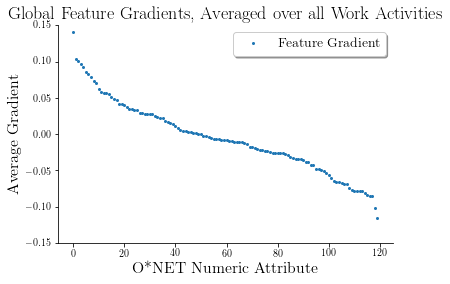

In [76]:
X_subset = X[cols].values
n = X_subset.shape[0]
y_subset = y.reshape(n,)
    
grads_at = m.compute_posterior_grad_at(X_subset)[0]
a_grad = grads_at.mean(axis=0)

global_AGs = [ (cols[cnt], cnt, i)  for cnt, i in enumerate(a_grad)]
l = [y[2] for y in sorted(global_AGs, key=lambda x: x[2])][::-1]

fig, ax = plt.subplots()
ax.plot(range(len(cols)), l, 'o', markersize=2)

ax.set_ylabel("Average Gradient", fontsize=16)
ax.set_xlabel("O*NET Numeric Attribute", fontsize=16)
ax.set_title("Global Feature Gradients, Averaged over all Work Activities", fontsize=18)
ax.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_ylim([-0.15, 0.15])

ax.legend(["Feature Gradient"], loc=1, shadow=True, fancybox=True, fontsize=14)

out_file_path = "/home/scpd/Dropbox/Documents/Oxford/writing/FutureOfHealthcare_project_docs/FinalReports/Analysis_images/"
name = 'all_gradients_sorted'
fig.savefig(out_file_path+name+".pdf", bbox_inches="tight")
fig.savefig(out_file_path+name+".png", bbox_inches="tight")
